# Autoencoders

> An autoencoder is a neural network that is trained to learn efficient representations of the input data (i.e., the features).

### Contents

1. Hyperparameter Search
2. Deep Autoencoders
3. Sparse Autoencoders
4. Denoising Autoencoders
5. Anomaly Detection

In [37]:
import torch
import torch.nn as nn
import numpy as np

import skorch
from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

import torchvision.datasets as datasets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import pandas as pd

from scipy.special import kl_div

In [2]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

In [3]:
# Hyperparameters
batch_size_      = 64
num_epochs_      = 15
input_dimension_ = 32*32*3
laten_dimension_ = 256
learning_rate_   = 0.0001

In [4]:
train_set = datasets.CIFAR10(root='./data',
                             train=True,
                             download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [5]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size_, shuffle=True)

## Architecture

In [6]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dim),
            nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        latent = self.encoder(x)
        self.latent_ = latent
        reconstructed = self.decoder(latent)
        return reconstructed

## 1. Hyperparameter Search

In [7]:
features = torch.stack([train_set[i][0].view(-1) for i in range(len(train_set))]).numpy()
targets = features

In [8]:
earlystopping = skorch.callbacks.EarlyStopping(monitor = 'train_loss', lower_is_better = False, patience = 10)
checkpoint = skorch.callbacks.Checkpoint(monitor = 'train_loss_best')

In [9]:
AutoencoderModel = NeuralNetRegressor(module=Autoencoder,
                                      module__input_dim=32 * 32 * 3, 
                                      module__latent_dim=128, 
                                      callbacks = [earlystopping, checkpoint],
                                      criterion=nn.MSELoss,
                                      train_split=None,
                                      max_epochs=15,                                        
                                      batch_size=64,
                                      device=dev,
                                      lr=0.01)

In [10]:
GridModel = {'lr': [0.0001, 0.001, 0.01],
             'batch_size': [32, 64]}

In [11]:
grid_search = GridSearchCV(AutoencoderModel,
                           param_grid=GridModel,
                           scoring='neg_mean_squared_error',
                           refit=True,                       
                           cv=2,                             
                           verbose=1)

In [12]:
grid_result = grid_search.fit(features, targets)

Fitting 2 folds for each of 6 candidates, totalling 12 fits
  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.0638     +  3.3011
      2        0.0638     +  3.0246
      3        0.0638     +  2.7730
      4        0.0638     +  2.8733
      5        0.0638     +  2.8554
      6        0.0638     +  2.8606
      7        0.0638     +  2.7992
      8        0.0638     +  2.3276
      9        0.0638     +  2.7717
     10        0.0638     +  2.7770
Stopping since train_loss has not improved in the last 10 epochs.
  epoch    train_loss    cp     dur
-------  ------------  ----  ------
      1        0.0643     +  3.1507
      2        0.0643     +  3.1334
      3        0.0643     +  3.1054
      4        0.0643     +  3.1362
      5        0.0643     +  2.6928
      6        0.0643     +  3.0991
      7        0.0643     +  2.8486
      8        0.0643     +  2.8232
      9        0.0643     +  2.8410
     10        0.0643     +  2.8542
Stopping s

In [13]:
print("Best Parameters:", grid_result.best_params_)
print("Best Score:", -grid_result.best_score_)
grid_dict = grid_result.cv_results_

Best Parameters: {'batch_size': 32, 'lr': 0.01}
Best Score: 0.06399858370423317


In [14]:
pd.DataFrame({'param_lr': grid_dict['param_lr'],
              'param_batch_size': grid_dict['param_batch_size'],
              'mean_test_score': -grid_dict['mean_test_score'],
              'std_test_score': grid_dict['std_test_score']},
              index=pd.Index(grid_dict['rank_test_score'], name='rank_test_score'))

,param_lr,param_batch_size,mean_test_score,std_test_score
rank_test_score,,,,
6,0.0001,32,0.064045,0.000265
3,0.0010,32,0.064027,0.000261
1,0.0100,32,0.063999,0.000274
5,0.0001,64,0.064036,0.000262
4,0.0010,64,0.064027,0.000264
2,0.0100,64,0.064015,0.000264


## 2. Deep Autoencoders

In [15]:
model = Autoencoder(input_dimension_, laten_dimension_)
model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [16]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate_,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=0,
                             amsgrad=False)

In [17]:
for epoch in range(num_epochs_):
    model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        optimizer.zero_grad()
        outputs = model(images)
        flat_images = images.view(images.size(0), -1)
        loss = criterion(outputs, flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0370
Epoch [2/15], Loss: 0.0237
Epoch [3/15], Loss: 0.0214
Epoch [4/15], Loss: 0.0192
Epoch [5/15], Loss: 0.0172
Epoch [6/15], Loss: 0.0162
Epoch [7/15], Loss: 0.0155
Epoch [8/15], Loss: 0.0146
Epoch [9/15], Loss: 0.0138
Epoch [10/15], Loss: 0.0132
Epoch [11/15], Loss: 0.0128
Epoch [12/15], Loss: 0.0124
Epoch [13/15], Loss: 0.0121
Epoch [14/15], Loss: 0.0118
Epoch [15/15], Loss: 0.0115


In [18]:
with torch.no_grad():
    for data_a, _ in train_loader:
        data_a = data_a.to(dev)
        recon = model(data_a)
        break
recon1 = recon.view(64, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

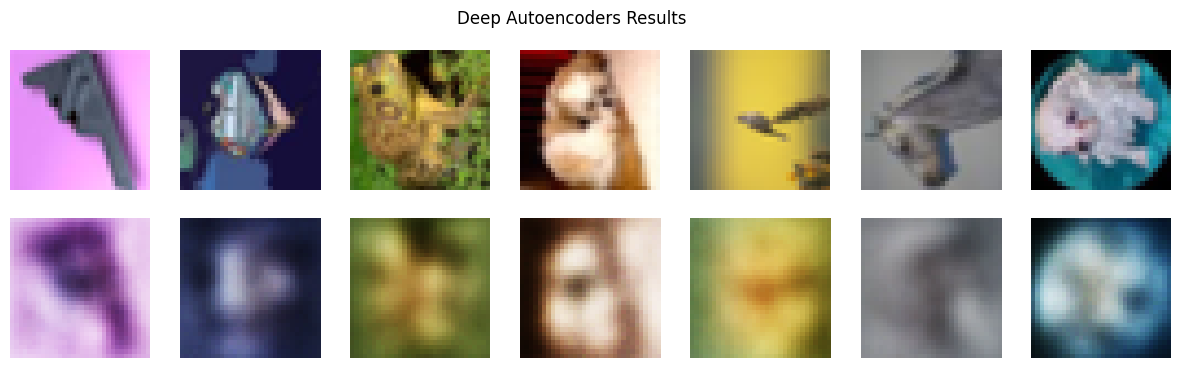

In [19]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Deep Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_a[i].cpu().numpy().T)
    ax[1, i].imshow(recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 3. Sparse Autoencoders

In [20]:
# Additional hyperparameters
beta = 0.0001
rho  = 0.05

In [21]:
sparse_model = Autoencoder(input_dimension_, laten_dimension_)
sparse_model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [22]:
sparse_criterion = nn.MSELoss()
sparse_optimizer = torch.optim.Adam(sparse_model.parameters(),
                                    lr=learning_rate_,
                                    betas=(0.9, 0.999),
                                    eps=1e-08,
                                    weight_decay=0,
                                    amsgrad=False)

In [23]:
for epoch in range(num_epochs_):
    sparse_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images = images.to(dev)
        sparse_optimizer.zero_grad()
        outputs = sparse_model(images)
        flat_images = images.view(images.size(0), -1)
        rho_ = torch.mean(sparse_model.latent_).cpu().item()
        sparse_penalty = beta*kl_div(rho,rho_)
        loss = sparse_criterion(outputs,flat_images) + sparse_penalty
        with torch.no_grad():
          train_loss += loss.item()
        sparse_optimizer.zero_grad()
        loss.backward()
        sparse_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0367
Epoch [2/15], Loss: 0.0239
Epoch [3/15], Loss: 0.0216
Epoch [4/15], Loss: 0.0195
Epoch [5/15], Loss: 0.0174
Epoch [6/15], Loss: 0.0164
Epoch [7/15], Loss: 0.0156
Epoch [8/15], Loss: 0.0147
Epoch [9/15], Loss: 0.0139
Epoch [10/15], Loss: 0.0133
Epoch [11/15], Loss: 0.0128
Epoch [12/15], Loss: 0.0124
Epoch [13/15], Loss: 0.0121
Epoch [14/15], Loss: 0.0118
Epoch [15/15], Loss: 0.0115


In [24]:
with torch.no_grad():
    for data_b, _ in train_loader:
        data_b = data_b.to(dev)
        sparse_recon = sparse_model(data_b)
        break
sparse_recon1 = sparse_recon.view(64, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

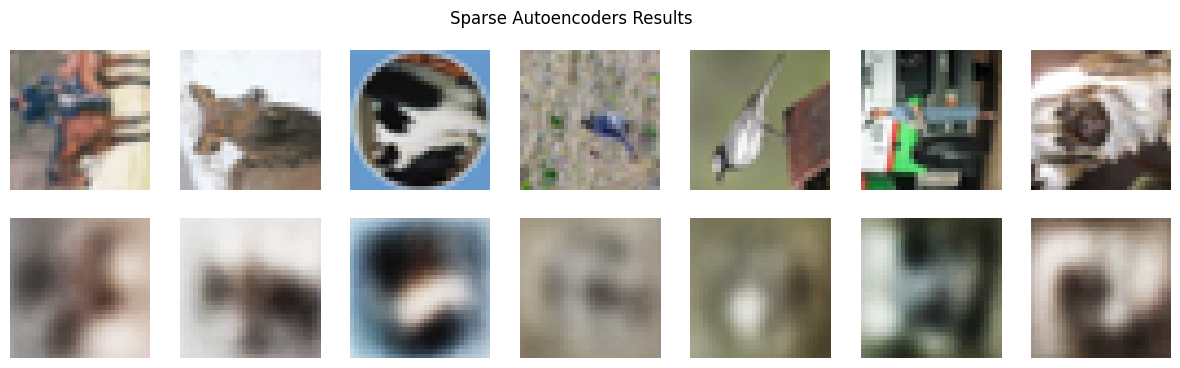

In [25]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Sparse Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_b[i].cpu().numpy().T)
    ax[1, i].imshow(sparse_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 4. Denoising Autoencoders

In [26]:
# Additional hyperparameters
noise = 0.1

In [27]:
denoising_model = Autoencoder(input_dimension_, laten_dimension_)
denoising_model.to(dev)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=3072, bias=True)
    (5): Sigmoid()
  )
)

In [28]:
denoising_criterion = nn.MSELoss()
denoising_optimizer = torch.optim.Adam(denoising_model.parameters(),
                                       lr=learning_rate_,
                                       betas=(0.9, 0.999),
                                       eps=1e-08,
                                       weight_decay=0,
                                       amsgrad=False)

In [29]:
for epoch in range(num_epochs_):
    denoising_model.train()
    train_loss = 0.0
    for images, _ in train_loader:
        images_noisy = images + noise * torch.randn(images.shape)
        images_noisy = np.clip(images_noisy, 0., 1.)
        images_noisy = images_noisy.to(dev)
        denoising_optimizer.zero_grad()
        outputs = denoising_model(images_noisy)
        flat_images = images_noisy.view(images_noisy.size(0), -1)
        loss = denoising_criterion(outputs,flat_images)
        with torch.no_grad():
          train_loss += loss.item()
        denoising_optimizer.zero_grad()
        loss.backward()
        denoising_optimizer.step()        
    train_loss /= len(train_loader)    
    print(f"Epoch [{epoch+1}/{num_epochs_}], Loss: {train_loss:.4f}")

Epoch [1/15], Loss: 0.0445
Epoch [2/15], Loss: 0.0319
Epoch [3/15], Loss: 0.0295
Epoch [4/15], Loss: 0.0274
Epoch [5/15], Loss: 0.0255
Epoch [6/15], Loss: 0.0246
Epoch [7/15], Loss: 0.0239
Epoch [8/15], Loss: 0.0231
Epoch [9/15], Loss: 0.0225
Epoch [10/15], Loss: 0.0219
Epoch [11/15], Loss: 0.0214
Epoch [12/15], Loss: 0.0211
Epoch [13/15], Loss: 0.0207
Epoch [14/15], Loss: 0.0203
Epoch [15/15], Loss: 0.0200


In [30]:
with torch.no_grad():
    for data_c, _ in train_loader:
        data_c = data_c + noise * torch.randn(data_c.shape)
        data_c = np.clip(data_c, 0., 1.)
        data_c = data_c.to(dev)
        denoising_recon = denoising_model(data_c)
        break
denoising_recon1 = denoising_recon.view(64, 3, 32, 32)

<Figure size 1600x1200 with 0 Axes>

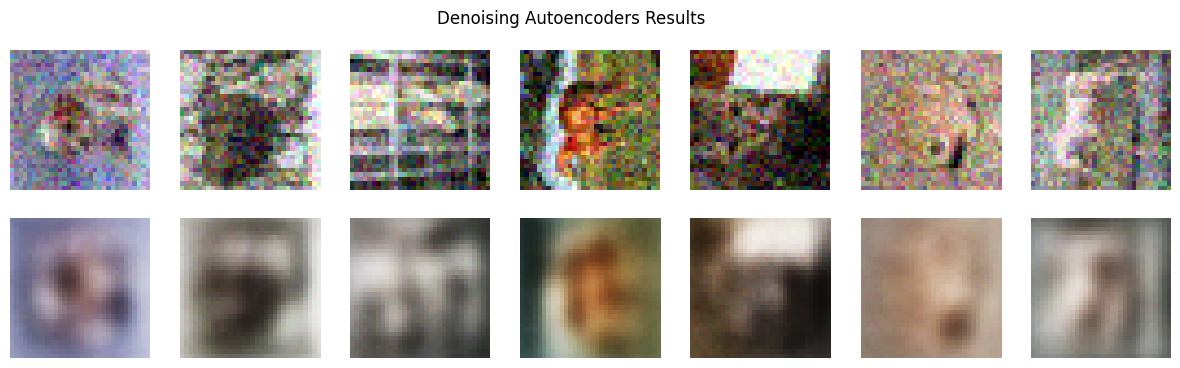

In [31]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, 7, figsize=(15, 4))
fig.suptitle('Denoising Autoencoders Results')
for i in range(7):
    ax[0, i].imshow(data_c[i].cpu().numpy().T)
    ax[1, i].imshow(denoising_recon1[i].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()

## 5. Anomaly Detection

In [32]:
# Additional hyperparameters
anomaly_sample = 7

In [33]:
all_images = []
anomaly_loss = []
feature_images = []
target_images = []
with torch.no_grad():
    for anomaly_images, _ in train_loader:
        anomaly_images = anomaly_images.to(dev)
        anomaly_recon = model(anomaly_images)
        anomaly_flat_images = anomaly_images.view(anomaly_images.size(0), -1)
        batch_size = anomaly_recon.shape[0]
        for i_batch in range(batch_size):
          i_loss = criterion(anomaly_recon[i_batch],anomaly_flat_images[i_batch]).cpu()
          anomaly_loss.append(i_loss.numpy())
          feature_images.append(anomaly_images[i_batch])
          target_images.append(anomaly_recon[i_batch].view(3, 32, 32))
anomaly_loss = np.array(anomaly_loss)

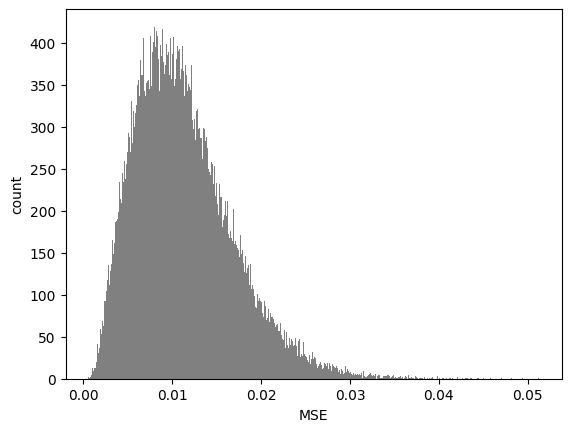

In [34]:
plt.hist(anomaly_loss, bins=500, color='grey')
plt.xlabel("MSE")
plt.ylabel("count")
plt.show()

In [35]:
anomalies_indx = np.argsort(anomaly_loss)[-anomaly_sample:]

<Figure size 1600x1200 with 0 Axes>

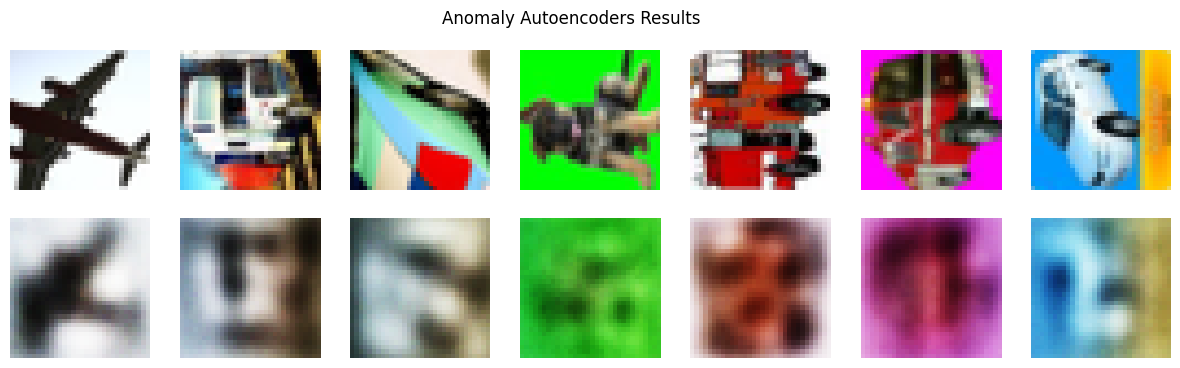

In [36]:
plt.figure(dpi=250)
fig, ax = plt.subplots(2, anomaly_sample, figsize=(15, 4))
fig.suptitle('Anomaly Autoencoders Results')
for i in range(anomaly_sample):
    ax[0, i].imshow(feature_images[anomalies_indx[i]].cpu().numpy().T)
    ax[1, i].imshow(target_images[anomalies_indx[i]].cpu().numpy().T)
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
plt.show()